In [2]:
import matplotlib.pylab as plt
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
import pandas as pd

In [3]:
# load file
import numpy as np
# f = np.load("./model_maxtime_combine_jobs_DSNB_sk_data/predict_0.npz", allow_pickle=True)
f = np.load("/afs/ihep.ac.cn/users/l/luoxj/sk_psd/model_maxtime_time_jobs_DSNB_sk_data/predict_0.npz", allow_pickle=True)
print(f"key: {f.files}")
predict_proba = f["predict_proba"][:,1]
equen = f["equen"]
vertex = f["vertex"]
labels = f["labels"]
pdgs = f["pdg_bkg"]
# print("predict_proba: ", predict_proba)
# print("labels: ", labels)
# print("pdg:  ", pdgs)

key: ['predict_proba', 'equen', 'vertex', 'labels', 'pdg_bkg', 'bkg_px', 'bkg_py', 'bkg_pz', 'bkg_x_init', 'bkg_y_init', 'bkg_z_init', 'bkg_x_nosmear', 'bkg_y_nosmear', 'bkg_z_nosmear']


In [4]:
# seperate sig and bkg
dir_proba ={}
dir_vertex = {}
dir_equen = {}
dir_proba["sig"] = predict_proba[labels==1]
dir_proba["bkg"] = predict_proba[labels==0]
dir_vertex["sig"] = vertex[labels==1]
dir_vertex["bkg"] = vertex[labels==0]
dir_equen["sig"] = equen[labels==1]
dir_equen["bkg"] = equen[labels==0]
x_init = f["bkg_x_init"]
y_init = f["bkg_y_init"]
z_init = f["bkg_z_init"]
x_nosmear = f["bkg_x_nosmear"]
y_nosmear = f["bkg_y_nosmear"]
z_nosmear = f["bkg_z_nosmear"]

# print("Check bkg length: ")
# print("proba->  ", len(dir_proba["bkg"]))
# print("pdg-> ", len(pdgs))
# print("vertex-> ", len(dir_vertex["bkg"]))

In [5]:
# Study pdgs
from collections import Counter
def GetNucleiNum(pdg_evt):
    n_nuclei = 0
    counter = Counter(pdg_evt)
    for key in counter:
        if key > 1000000000:
            n_nuclei += counter[key]
    return n_nuclei

def PdgToN(Nuclei_pdg):
    N = int(Nuclei_pdg/10)%1000
    Z = int(Nuclei_pdg/10000)%1000
    return (N, Z)

class OneNucleiEvts:
    def __init__(self):
        self.probs = []
        self.v_NZ = []
    def Print(self):
        print(f"probs: {self.probs}")
        print(f"v_NZ: {self.v_NZ}")
evt_1Nuclei = OneNucleiEvts()

v_pdg_multi_nuclei = []
v_proba_multi_nuclei = []
v_pdgs_one_nuclei = []
v_whether_1Nuclei = []
for i, pdg_evt in enumerate(pdgs):
    n_nuclei = GetNucleiNum(pdg_evt)
    if n_nuclei == 1 :
        Nuclei_pdg = pdg_evt[pdg_evt>1000000000][0]
        (N, Z ) = PdgToN(Nuclei_pdg)
        evt_1Nuclei.probs.append(dir_proba["bkg"][i])
        evt_1Nuclei.v_NZ.append([N,Z])
        v_pdgs_one_nuclei.append(pdg_evt)
        v_whether_1Nuclei.append(True)
    else:
        v_proba_multi_nuclei.append(dir_proba["bkg"][i] )
        v_pdg_multi_nuclei.append(pdg_evt)
        v_whether_1Nuclei.append(False)
# evt_1Nuclei.Print()


## Find The Right Criteria

In [6]:
criteria_to_use = 0
for criteria in np.arange(0.9, 1, 0.0001 ):
    index_bkg_rightPredict = (dir_proba["bkg"]<criteria)
    counter_bkglike = Counter(index_bkg_rightPredict)
    eff_bkg = counter_bkglike[True]/len(index_bkg_rightPredict)

    index_sig_rightPredict = (dir_proba["sig"]>criteria)
    counter_sig_rightPredict = Counter(index_sig_rightPredict)
    eff_sig = counter_sig_rightPredict[True]/len(index_sig_rightPredict)
    if eff_bkg > 0.99:
        criteria_to_use = criteria
        print("Criteria :\t", criteria)
        print("Efficiency of bkg:\t", eff_bkg)
        print("Efficiency of sig:\t", eff_sig)
        print("###########################################")
        break
print("Will use criteria --> ", criteria_to_use)

Criteria :	 0.9492999999999946
Efficiency of bkg:	 0.990020623393379
Efficiency of sig:	 0.83967510824838
###########################################
Will use criteria -->  0.9492999999999946


## Check $^{11}C$ and $^{10}B$ Background (Signal like ratio)


In [7]:
def HistTimes(hist:np.ndarray, times:int):
    hist_return = list(hist)*times
    return np.array(hist_return)


<ipython-input-8-3e8c9ff070c9>:30: RuntimeWarning: invalid value encountered in true_divide
  h_ratio = np.nan_to_num(np.array(h_siglike)/((np.array(h_bkglike))+np.array(h_siglike)))


Text(0.5, 1.0, 'Ratio(Sig-like/Total)')

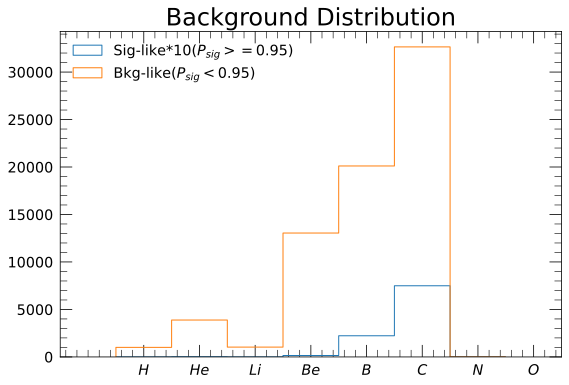

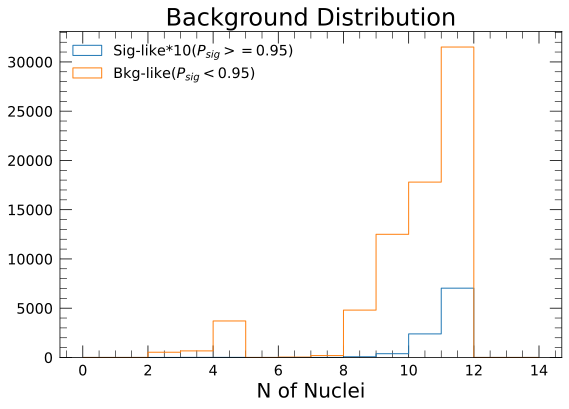

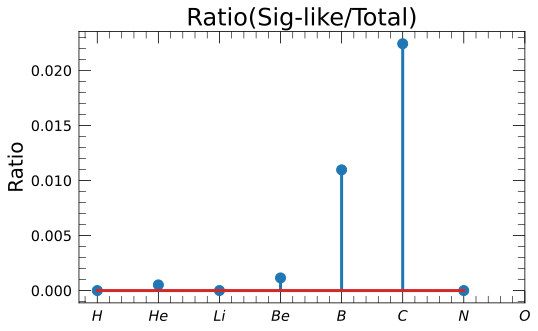

In [8]:
## Draw Nuclei distribution
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pylab as plt
criteria = criteria_to_use
index_siglike = (np.array(evt_1Nuclei.probs)>=criteria)
index_bkglike = (np.array(evt_1Nuclei.probs)<criteria)

labels = ["$H$", "$He$", "$Li$", "$Be$", "$B$", "$C$", "$N$", "$O$"]
plt.figure(figsize=(9, 6))
x =np.arange(1, len(labels)+1)
h_siglike = plt.hist(HistTimes(np.array(evt_1Nuclei.v_NZ)[index_siglike][:,1],10), bins=x , histtype='step', label="Sig-like*10($P_{sig}>=$"+"{:.2f}".format(criteria)+")")
h_bkglike = plt.hist(np.array(evt_1Nuclei.v_NZ)[index_bkglike][:,1], bins=x, histtype='step', label="Bkg-like($P_{sig}"+"<${:.2f}".format(criteria)+")")
plt.title("Background Distribution")
plt.xticks(x+0.5, labels)
plt.xlim([0, len(labels)+1])
# plt.xlabel("Z of Proton")
plt.legend(loc="upper left")

plt.figure(figsize=(9, 6))
plt.hist(HistTimes(np.array(evt_1Nuclei.v_NZ)[index_siglike][:,0],10), bins=range(0, 15), histtype='step', label="Sig-like*10($P_{sig}>=$"+"{:.2f}".format(criteria)+")")
plt.hist(np.array(evt_1Nuclei.v_NZ)[index_bkglike][:,0], bins=range(0, 15), histtype='step', label="Bkg-like($P_{sig}"+"<${:.2f}".format(criteria)+")")
plt.title("Background Distribution")
plt.xlabel("N of Nuclei")
plt.legend(loc="upper left")

plt.figure(figsize=(8, 5))
h_siglike = np.array(h_siglike[0])/10
h_bkglike = h_bkglike[0]
h_ratio = np.nan_to_num(np.array(h_siglike)/((np.array(h_bkglike))+np.array(h_siglike)))
plt.stem(h_ratio)
# plt.xlabel("Z of Proton")
plt.xticks(x-1, labels)
plt.ylabel("Ratio")
plt.title("Ratio(Sig-like/Total)")

# plt.show()

In [9]:

#handle multi-nuclei evt
# print(v_pdg_multi_nuclei, v_proba_multi_nuclei)
print(f"Total multi-nuclei : {len(v_proba_multi_nuclei)}")
v_proba_multi_nuclei = np.array(v_proba_multi_nuclei)
print(f"sig like : {len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)>=criteria])}" )
print(f"bkg like : {len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)<criteria])}" )
n_siglike_multi_nuclei = len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)>=criteria])
n_bkglike_multi_nuclei = len(v_proba_multi_nuclei[np.array(v_proba_multi_nuclei)<criteria])
h_bkglike = np.append(h_bkglike, [n_bkglike_multi_nuclei])
h_siglike = np.append(h_siglike, [n_siglike_multi_nuclei])

Total multi-nuclei : 29591
sig like : 32
bkg like : 29559


In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
Z = np.array(evt_1Nuclei.v_NZ)[:,1]
N = np.array(evt_1Nuclei.v_NZ)[:,0]
probs = np.array(evt_1Nuclei.probs)
from collections import Counter
counter_C = Counter(N[Z==6])

# h_C10 = plt.hist(probs[(Z==6) & (N==10)], bins=np.arange(0, 1, 0.05))
# plt.xlabel("PSD ouput")

print("Carbon:", counter_C)
print(np.array(v_pdgs_one_nuclei)[(Z==6) & (N==10)])
# plt.hist2d(N, Z, cmap=plt.hot())
# import pandas as pd
# pd.DataFrame(h_C10[1][:-1], h_C10[0])
counter_C11=Counter(probs[(Z==6) & (N==11)]>criteria)
counter_C10=Counter(probs[(Z==6) & (N==10)]>criteria)
counter_C9 =Counter(probs[(Z==6) & (N==9)]>criteria)
counter_B10 = Counter(probs[(Z==5) & (N==10)]>criteria)
counter_B9 =  Counter(probs[(Z==5) & (N==9)]>criteria)
counter_Be7 = Counter(probs[(Z==4) & (N==7)]>criteria)
print("C11", counter_C11)
print("C10", counter_C10)
print("C9 ", counter_C9)


Carbon: Counter({11: 32132, 10: 1265, 9: 3})
[array([        14,       2112,       2112, 1000060100], dtype=int32)
 array([        12,       2112,       2112, 1000060100], dtype=int32)
 array([      2112, 1000060100,         14,       2112], dtype=int32) ...
 array([      2112, 1000060100,         14,       2112], dtype=int32)
 array([        12,       2112,       2112, 1000060100], dtype=int32)
 array([       -14,       2112,       2112, 1000060100], dtype=int32)]
C11 Counter({False: 31429, True: 703})
C10 Counter({False: 1219, True: 46})
C9  Counter({False: 3})


<ipython-input-10-60b0e60e0a5c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(v_pdgs_one_nuclei)[(Z==6) & (N==10)])


In [11]:
C11_siglike = counter_C11[True]
C11_bkglike = counter_C11[False]
C10_siglike = counter_C10[True]
C10_bkglike = counter_C10[False]
C9_siglike = counter_C9[True]
C9_bkglike = counter_C9[False]
B10_siglike = counter_B10[True]
B9_siglike = counter_B9[True]
Be7_siglike = counter_Be7[True]
B10_bkglike = counter_B10[False]
B9_bkglike = counter_B9[False]
Be7_bkglike = counter_Be7[False]
h_C_bkglike = [C9_bkglike, C10_bkglike, C11_bkglike]
h_C_siglike = [C9_siglike, C10_siglike, C11_siglike]
h_siglike_main_compnent = [C11_siglike, B10_siglike, B9_siglike, C10_siglike, Be7_siglike]
h_bkglike_main_compnent = [C11_bkglike, B10_bkglike, B9_bkglike, C10_bkglike, Be7_bkglike]
print(h_siglike_main_compnent)
pd.DataFrame([h_C_bkglike, h_C_siglike ],
             index=["Background Like","Signal Like"], columns=["$^{9}C$","$^{10}C$","$^{11}C$"])

[703, 193, 30, 46, 0]


,$^{9}C$,$^{10}C$,$^{11}C$
Background Like,3,1219,31429
Signal Like,0,46,703


In [12]:
n_siglike_others = np.sum(h_siglike)-np.sum(h_siglike_main_compnent)
n_bkglike_others = np.sum(h_bkglike)-np.sum(h_bkglike_main_compnent)
label_main_component = ["$^{11}C$","$^{10}B$", "$^9B$", "$^{10}C$", "$^7Be$", "others" ]
pd.DataFrame([np.concatenate((h_siglike_main_compnent, [n_siglike_others])),
              np.concatenate((h_bkglike_main_compnent, [n_bkglike_others]))], index=["siglike", "bkglike"],columns=label_main_component)

,$^{11}C$,$^{10}B$,$^9B$,$^{10}C$,$^7Be$,others
siglike,703.0,193.0,30.0,46.0,0.0,49.0
bkglike,31429.0,16571.0,3445.0,1219.0,14.0,48612.0


In [13]:
h_siglike_main_compnent = np.concatenate((h_siglike_main_compnent, [n_siglike_others]))

[0.68854065 0.18903036 0.02938296 0.04505387 0.         0.04799216]
1021.0


,$^{11}C$,$^{10}B$,$^9B$,$^{10}C$,$^7Be$,others
Ratio,0.688541,0.18903,0.029383,0.045054,0.0,0.047992


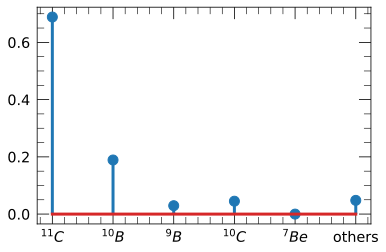

In [14]:
h_ratio_siglike_main_components = h_siglike_main_compnent/(np.sum(h_siglike_main_compnent))
label_main_component = ["$^{11}C$","$^{10}B$", "$^9B$", "$^{10}C$", "$^7Be$", "others" ]
plt.stem(label_main_component, h_ratio_siglike_main_components)
print(h_ratio_siglike_main_components)
print(np.sum(h_siglike))
pd.DataFrame([h_ratio_siglike_main_components], columns=label_main_component, index=["Ratio"] )

[0.         0.00195886 0.         0.01469148 0.21841332 0.73359452
 0.         0.03134182]


,$H$,$He$,$Li$,$Be$,$B$,$C$,$N$,Multi-nuclei
Background Like,1008,3886,1034,13044,20108,32651,0,29559
Signal Like,0,2,0,15,223,749,0,32


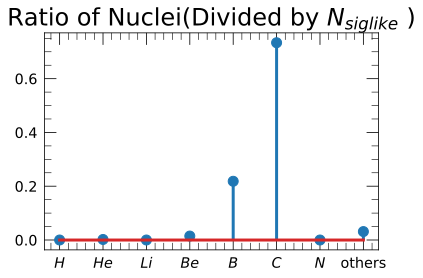

In [15]:
index_C = np.where(np.array(labels)=="$C$")[0][0]
table = pd.DataFrame([np.array(h_bkglike , dtype=np.int),np.array(h_siglike, dtype=np.int)], index=["Background Like", "Signal Like"], columns=labels[:-1]+["Multi-nuclei"])
h_ratio_siglike = np.array(h_siglike)/np.sum(h_siglike)
print(h_ratio_siglike)
plt.stem(labels[:-1]+["others"],h_ratio_siglike)
plt.title("Ratio of Nuclei(Divided by $N_{siglike}$ )")
table

In [16]:
total_evts = np.sum(h_siglike)+np.sum(h_bkglike)
h_bkglike_ratio_to_total = h_bkglike/total_evts
h_siglike_ratio_to_total = h_siglike/total_evts
table = pd.DataFrame([np.array(h_bkglike_ratio_to_total , dtype=np.float),np.array(h_siglike_ratio_to_total, dtype=np.float)], index=["Background Like", "Signal Like"], columns=labels[:-1]+["Multi-nuclei"])
table

,$H$,$He$,$Li$,$Be$,$B$,$C$,$N$,Multi-nuclei
Background Like,0.009852,0.037982,0.010106,0.127494,0.196538,0.319135,0.0,0.288913
Signal Like,0.000000,0.000020,0.000000,0.000147,0.002180,0.007321,0.0,0.000313


## C and C efficiency ( divided by total events )

In [17]:
ratio_C = [ h_siglike_ratio_to_total[index_C], h_bkglike_ratio_to_total[index_C]]
ratio_noC = [np.sum(h_siglike_ratio_to_total)-h_siglike_ratio_to_total[index_C], np.sum(h_bkglike_ratio_to_total)-h_bkglike_ratio_to_total[index_C]]
pd.DataFrame(np.array([ratio_C, ratio_noC]).T, columns=["C", "no-C"], index=["Signal Like", "Background Like"])

,C,no-C
Signal Like,0.007321,0.002659
Background Like,0.319135,0.670886


## C11 and no-C11 efficiency ( divided by total events)

In [18]:
ratio_C11_bkglike = C11_bkglike/total_evts
ratio_noC11_bkglike = (np.sum(h_bkglike)-C11_bkglike)/total_evts
ratio_C11_siglike = C11_siglike/total_evts
ratio_noC11_siglike = (np.sum(h_siglike)-C11_siglike)/total_evts

print(total_evts)
pd.DataFrame(np.array([[ratio_C11_siglike, ratio_noC11_siglike], [ratio_C11_bkglike, ratio_noC11_bkglike]]), index=["Signal Like", "Background Like"], columns=["$^{11}C$", "no-$^{11}C$"])


102311.0


,$^{11}C$,no-$^{11}C$
Signal Like,0.006871,0.003108
Background Like,0.307191,0.682830


In [19]:
C_total = np.sum(h_C_bkglike)+np.sum(h_C_siglike)
print("C ratio:\t", C_total/total_evts)
C11_total = h_C_siglike[-1] + h_C_bkglike[-1]
no_C11_total = total_evts - C11_total
sub_ratio_C11_bkglike = C11_bkglike/C11_total
sub_ratio_noC11_bkglike = (np.sum(h_bkglike)-C11_bkglike)/no_C11_total
sub_ratio_C11_siglike = C11_siglike/C11_total
sub_ratio_noC11_siglike = (np.sum(h_siglike)-C11_siglike)/no_C11_total
print("C11_ratio:\t", C11_total/total_evts)
pd.DataFrame(np.array([[sub_ratio_C11_siglike, sub_ratio_noC11_siglike], [sub_ratio_C11_bkglike, sub_ratio_noC11_bkglike]]), index=["Signal Like", "Background Like"], columns=["$^{11}C$", "no-$^{11}C$"])

C ratio:	 0.3264556108336347
C11_ratio:	 0.3140620265660584


,$^{11}C$,no-$^{11}C$
Signal Like,0.021879,0.004531
Background Like,0.978121,0.995469


In [20]:
# Study C11 vertex_init and vertex_deposit
x_init_first = []
y_init_first = []
z_init_first = []
for i in range(len(x_init)):
    x_init_first.append(x_init[i][0])
    y_init_first.append(y_init[i][0])
    z_init_first.append(z_init[i][0])
x_init_first = np.array(x_init_first)
y_init_first = np.array(y_init_first)
z_init_first = np.array(z_init_first)

In [21]:
print(x_nosmear)
print(x_init_first)

[-12491.20056453  13984.21421681   3271.82176805 ...   3190.70271423
  -5703.82794103  -2767.41286816]
[-12680.95214844  13703.11425781   3131.30517578 ...   3189.38061523
  -5701.00048828  -2766.90844727]


In [22]:
index_C11 = ((Z==6) & (N==11))
d_Einit2Edep_C11 = ((x_init_first[v_whether_1Nuclei][index_C11]-x_nosmear[v_whether_1Nuclei][index_C11])**2+\
                    (y_init_first[v_whether_1Nuclei][index_C11]-y_nosmear[v_whether_1Nuclei][index_C11])**2+\
                    (z_init_first[v_whether_1Nuclei][index_C11]-z_nosmear[v_whether_1Nuclei][index_C11])**2)**0.5

Text(0.5, 1.0, '$^{11}C$ distance distribution')

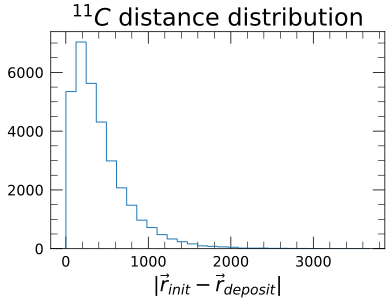

In [23]:
plt.hist(d_Einit2Edep_C11, bins=30,histtype="step")
plt.xlabel(r"$|\vec{r}_{init}-\vec{r}_{deposit}|$")
plt.title("$^{11}C$ distance distribution")

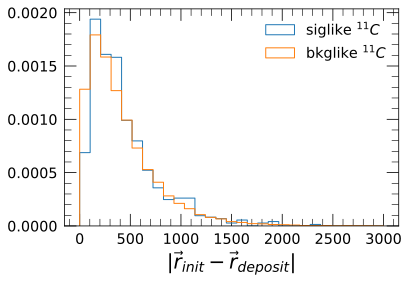

In [24]:
prob_C11 = np.array(evt_1Nuclei.probs)[index_C11]
bins_c11 = np.linspace(0, 3000, 30)
plt.hist(d_Einit2Edep_C11[prob_C11>criteria], bins=bins_c11, label="siglike $^{11}C$", histtype="step", density=True  )
plt.hist(d_Einit2Edep_C11[prob_C11<=criteria],bins=bins_c11, label="bkglike $^{11}C$", histtype="step", density=True  )
plt.xlabel(r"$|\vec{r}_{init}-\vec{r}_{deposit}|$")
plt.legend()


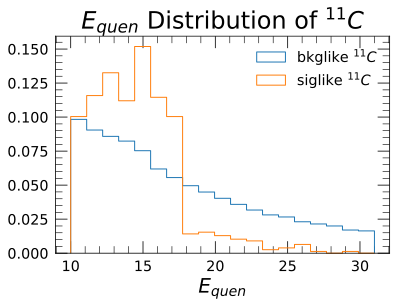

In [36]:
equen_bkg_c11 = dir_equen["bkg"][v_whether_1Nuclei][index_C11]
bins_equen = np.linspace(10, 31, 20)
plt.hist(equen_bkg_c11[prob_C11<=criteria], histtype="step",bins=bins_equen,  density=True, label="bkglike $^{11}C$")
plt.hist(equen_bkg_c11[prob_C11>criteria], histtype="step", bins=bins_equen,  density=True , label="siglike $^{11}C$")
plt.xlabel("$E_{quen}$")
plt.title("$E_{quen}$ Distribution of $^{11}C$")
plt.legend()
